## Introduction

Have you ever wondered how deploying a liquidity position in Uniswap V3 compares to selling Panoptic options? In this article, we delve into a detailed analysis and comparison of these two financial instruments. Specifically, we'll compute and contrast the fees accrued from both Uniswap V3 liquidity provision and Panoptic options trading, and compare them to a 'vanilla, European' position as our benchmark.

Understanding the similarities and differences between Uniswap V3 liquidity positions and Panoptic options trading isn't just an academic exercise. It equips us with valuable insights, enabling more informed investment decisions by identifying potential opportunities, assessing risks, and maximizing the value of our investments.

By the end of this exploration, you'll gain a nuanced understanding of the similarities and differences between these two seemingly disparate financial concepts.

In this deep dive, we will:

- Analyze and calculate fees from a Uniswap V3 liquidity position, extracting relevant data from that protocol.
- Compare these findings with the [stremia](https://panoptic.xyz/blog/streamia-defi-native-options-pricing) model used by Panoptic.
- Compare to a similar vanilla European position, priced via the Black-Scholes Model.




## Setup

In this deep dive we will focus on [position 552524](https://app.uniswap.org/pool/552524) of the ETH-USDC-0.05% pool between blocks 17944664 and 18416712 (roughly corresponding to a range between August 18th, 2023 and October 22rd, 2023). This position provided 403 USDC and 0.36 ETH between ticks 201590 and 202540, corresponding to a liquidity range of $p_a=1600.44$ and $p_b=1759.93$. At the time of deployment, the price of the pool was 1662.75 USDC per WETH, and the price at the final block considered was 1775.30 USDC per ETH. 



**Note:** *At the time of writing this article, our reference position was still active. To ensure clarity in our analysis, we've chosen October 22nd, 2023 as a cut-off date.*




## Fee Collection in Uniswap V3 Pools: A Brief Overview

In this section, we will provide a concise overview of how fees are collected within a Uniswap V3 pool.

Instead of updating fees for each position after every swap, Uniswap V3 employs a global fee tracking system. This system is represented by two state variables, `feeGrowthGlobal0X128` and `feeGrowthGlobal1X128`. These variables can be accessed from the [pool contract](https://etherscan.io/address/0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640#readContract) and denote the total accumulated fees **per unit of liquidity** (i.e., accumulated fees divided by the total liquidity in the pool) for each respective token since the inception of the pool. Specifically, after a swap occurs within a Uniswap V3 pool, if it does not alter the price beyond a single tick, these accumulators increase proportionally to the fees generated per unit of total liquidity present in that tick. If the swap crosses a tick boundary, the Uniswap V3Pool records the fees collected up to that point for that specific tick range.

Furthermore, ticks also maintain records of fees accrued outside their boundaries. This mechanism is vital for determining the total fees gathered within a specific position (a position being the range between two ticks).

To elaborate, the fees (per unit of liquidity) accrued by a position situated between ticks $i_l$ and $i_u$ can be calculated. This is done by subtracting the fees accumulated outside both the lower and upper ticks from the total global fees. Let's formalize this concept.

For any tick, $i$, let $f^j_o(i)$ represent the fees of token $j$, where $j=0,1$, collected outside tick $i$. Likewise, let $f_g^j$ denote `feeGrowthGlobal{j}X128`, for $j=0,1$. The total fees per unit of liquidity collected for a position deployed between ticks $i_l$ and $i_u$ are then given by $f_r^j$, defined by

\begin{aligned}
f_r^j=f_g^j-f^j_b(i_l)-f_a^j(i_u).
\end{aligned}

Here, $f_b(i_l)$ represents the fees accumulated below the lower tick, and $f_a(i_u)$ represents the fees accumulated above the upper tick. These are further defined as

\begin{aligned}
f^j_b(i):=\begin{cases}
f_o^j(i) \quad & i_c\geq i\\
f_g^i-f_o^j(i) \quad & i_c< i\\
\end{cases},\quad \text{and} \quad 
f_a(i)=\begin{cases}
f_o^j(i) \quad & i_c< i\\
f_g^i-f_o^j(i) \quad & i_c\geq i\\
\end{cases},
\end{aligned}



where $i_c$ corresponds to the tick associated with the current price. It's important to note that $f_g^j$ and $f_o^j$ are attributes of the pool and can be obtained by calling the `feeGrowthGlobal0X128`, `feeGrowthGlobal1X128`, and `ticks(i:int24)` functions of the pool smart contract. This information can be obtained from the the [pool contract](https://etherscan.io/address/0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640#readContract)) and the  [position manager contract](https://etherscan.io/address/0xC36442b4a4522E871399CD717aBDD847Ab11FE88#readContract).

Finally, denoting the deployed liquidity of the position by $\ell$, we can compute the amount of uncollected fees for each token between times $t_0$ and $t_1$ as:

\begin{aligned}
\mathsf{Fees\ Token0}=\mathsf{\ell}\times\left(
\frac{f^0_r(t_1)-f^0_r(t_0)}{2^{128}}\right), \\
\mathsf{Fees\ Token1}=\mathsf{\ell}\times\left(
\frac{f^1_r(t_1)-f^1_r(t_0)}{2^{128}}\right), \\
\end{aligned}

where, with a slight abuse of notation, we used $f_r^j(t),\ j=0,1$, to denote the uncollected fees of the position at some time $t$.

Note that we divide by $2^{128}$ because $f^j_g$ and $f_o^j$ are represented in [Q128 arithmetic](https://en.wikipedia.org/wiki/Q_(number_format)). All the required values can be obtained from the blockchain using `web3.py` and an Infura node.



In [1]:
from web3 import Web3
import json
from IPython.display import display, Markdown

# Constants
INITIAL_BLOCK = 17944664
FINAL_BLOCK = 18416712
TOKEN_ID = 552524
MODULUS = 2**256
POOL_ADDRESS = "0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640"
POSITION_MANAGER_ADDRESS = "0xC36442b4a4522E871399CD717aBDD847Ab11FE88"
BASE=1.0001
def calculate_fa(fg, fo, i, ic):
    """Compute value of 'fa' based on conditions."""
    return fg - fo if i <= ic else fo

def calculate_fb(fg, fo, i, ic):
    """Compute value of 'fb' based on conditions."""
    return fo if i <= ic else fg - fo

def get_pool_and_position_contracts(w3, pool_address, position_manager_address, pool_abi, nft_abi):
    """Initialize contracts for pool and position manager."""
    pool_contract = w3.eth.contract(address=pool_address, abi=pool_abi)
    position_manager_contract = w3.eth.contract(address=position_manager_address, abi=nft_abi)
    return pool_contract, position_manager_contract

def get_position_data_at_creation(position_manager_contract):
    """Retrieve position data based on the token id and initial block."""
    position_data = position_manager_contract.functions.positions(TOKEN_ID).call(block_identifier=INITIAL_BLOCK)
    return position_data

def compute_fees(initial_block: int, 
                 final_block: int,
                 position_id: int, 
                 pool: str, 
                 decimals0: int = 6,
                 decimals1: int = 18):
    
    w3 = Web3(Web3.HTTPProvider('https://mainnet.infura.io/v3/3228fac9b6294c2b8ce6a4a39a5b96e5'))
    
    # Load ABIs
    with open('uniswapV3PoolABI.json', 'r') as abi_file:
        pool_abi = json.load(abi_file)
    with open('position_manager_abi.json', 'r') as abi_file2:
        nft_abi = json.load(abi_file2)

    pool_contract, position_manager_contract = get_pool_and_position_contracts(w3, pool, POSITION_MANAGER_ADDRESS, pool_abi, nft_abi)
    position_data = position_manager_contract.functions.positions(position_id).call(block_identifier=initial_block)
    
    # Extracting relevant position data details
    LOWER_TICK = position_data[5]
    UPPER_TICK = position_data[6]
    liquidity = position_data[7]
    feeGrowthInside0LastX128 = position_data[8]
    feeGrowthInside1LastX128 = position_data[9]

    # Extract final pool values
    fee_growth_global_0_final = pool_contract.functions.feeGrowthGlobal0X128().call(block_identifier=final_block)
    fee_growth_global_1_final = pool_contract.functions.feeGrowthGlobal1X128().call(block_identifier=final_block)
    tick_info_lower_final = pool_contract.functions.ticks(LOWER_TICK).call(block_identifier=final_block)
    tick_info_upper_final = pool_contract.functions.ticks(UPPER_TICK).call(block_identifier=final_block)
    slot0 = pool_contract.functions.slot0().call(block_identifier=final_block)
    current_tick = slot0[1]

    # Compute values for fb and fa
    fb0 = calculate_fb(fee_growth_global_0_final, tick_info_lower_final[2], LOWER_TICK, current_tick)
    fb1 = calculate_fb(fee_growth_global_1_final, tick_info_lower_final[3], LOWER_TICK, current_tick)
    fa0 = calculate_fa(fee_growth_global_0_final, tick_info_upper_final[2], UPPER_TICK, current_tick)
    fa1 = calculate_fa(fee_growth_global_1_final, tick_info_upper_final[3], UPPER_TICK, current_tick)

    # Compute fee differences
    diff0 = (fb0 + fa0) % MODULUS
    diff1 = (fb1 + fa1) % MODULUS
    fr0 = (fee_growth_global_0_final - diff0) % MODULUS
    fr1 = (fee_growth_global_1_final - diff1) % MODULUS

    # Compute fees in tokens
    fees_token0 = liquidity * (fr0 - feeGrowthInside0LastX128) / 2**128
    fees_token1 = liquidity * (fr1 - feeGrowthInside1LastX128) / 2**128

    p1=BASE**(-current_tick)*10**(decimals1-decimals0)


    res= {'fees0':fees_token0/10**decimals0,
            'fees1':fees_token1/10**decimals1,
             'price1':p1,
              'total_fees':fees_token0/10**decimals0+p1*fees_token1/10**decimals1,
             'block':final_block}    
    return res
    
res=compute_fees(initial_block=INITIAL_BLOCK, 
                 final_block=FINAL_BLOCK,
                 position_id=TOKEN_ID, 
                 pool=POOL_ADDRESS, 
                 decimals0 = 6,
                 decimals1= 18)
print(res)

{'fees0': 35.480551703249915, 'fees1': 0.021288616540653504, 'price1': 1775.3068563201662, 'total_fees': 73.27437860944298, 'block': 18416712}


Which matches the results: 

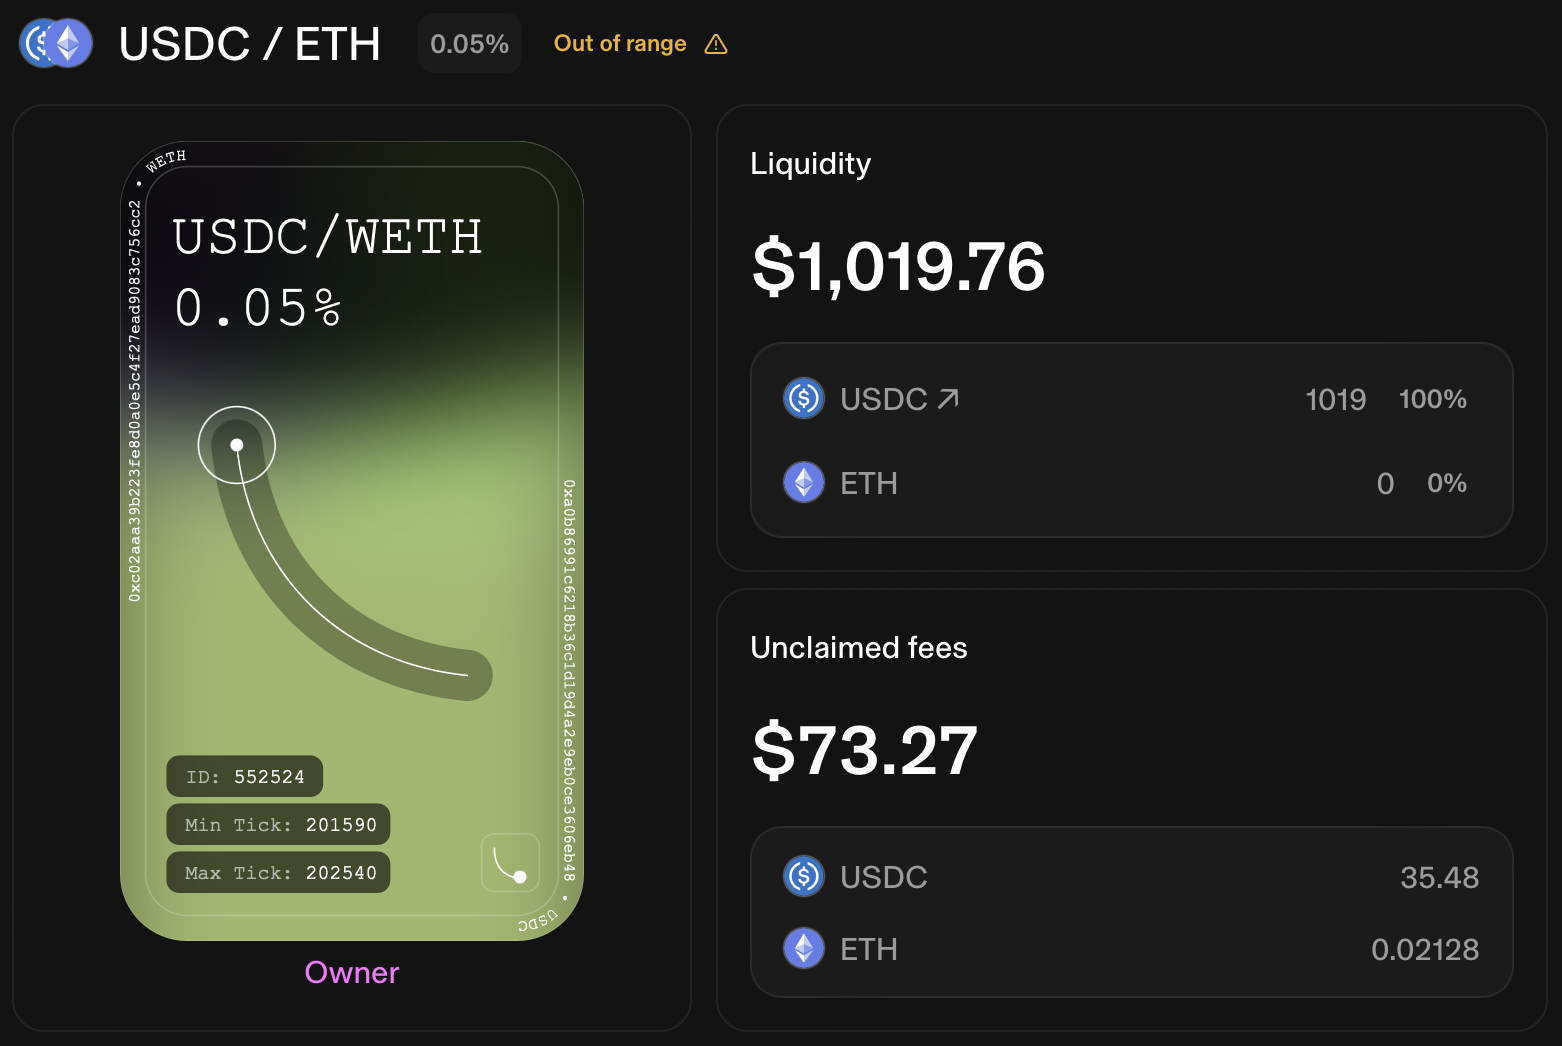

In [2]:
import tqdm
N_epochs=FINAL_BLOCK-INITIAL_BLOCK
res=[]
for i in tqdm.tqdm(range(INITIAL_BLOCK+1,FINAL_BLOCK+1,5*60*24)):
    aux=compute_fees(initial_block=INITIAL_BLOCK, 
                 final_block=i,
                 position_id=TOKEN_ID, 
                 pool=POOL_ADDRESS, 
                 decimals0 = 6,
                 decimals1= 18)
    res.append(aux)

100%|███████████████████████████████████████████| 66/66 [01:21<00:00,  1.23s/it]


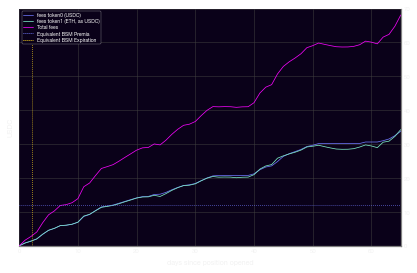

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('panoptic-dark-16:9.mplstyle')

df=pd.DataFrame(res)
plt.plot(df['fees0'],label='fees token0 (USDC)')
plt.plot(df['fees1']*df['price1'],label='fees token1 (ETH, as USDC)')
plt.plot(df['total_fees'],label='Total fees')
plt.hlines(12.1,0,65,linestyle=':',label='Equivalent BSM Premia')
plt.vlines(2.17,0,65,linestyle=':', color='C4',label='Equivalent BSM Expiration')
plt.legend()
plt.xlabel('days since position opened')
plt.xlim([0,65])
plt.ylim([0,70])
plt.ylabel('USDC')
plt.savefig('price_days.png')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('panoptic-dark-16:9.mplstyle')
decimals_ETH=18
decimals_USDC=6

price_diff=decimals_ETH-decimals_USDC

df=pd.read_csv('../../data/uniV3.csv')
df['price']=1.0001**(-df['tick'])*10**price_diff
df=df.sort_values(by='block_timestamp')
df.columns

In [ ]:
df['price'].tail()
mask=df['block_timestamp']>'2023-09-22'
plt.plot(df['block_number'][mask],df['price'][mask])


Running the code above shows that between blocks 17944664 and 18416712,  such a position has accumulated

- $\mathsf{Fees\ Token0}$= 35.480551703249915 USDC,
- $\mathsf{Fees\ Token1}$= 0.021288616540653504 WETH, 

which, at a price of 1775.30 USDC per WETH (i.e., the price at the block 18416712), corresponds to a total amount of fees given by 73.27 USDC. This agrees with the total amount of uncollected fees directly obtained from the protocol:

![](https://hackmd.io/_uploads/ByOEcmDzp.png)


The daily fees collected by such a position are shown below. Notice that this position stayed within range about 70% of the itme.

![](https://hackmd.io/_uploads/BkqCkz_Mp.png)

![](https://hackmd.io/_uploads/Sy5dp7Tza.png)





In the following section we investigate wether someone selling 
an equivalent Panoption would have been better off. (spoiler alert: yes!)




## Are we better off with Panoptic?

We know Panoptic is closely related to (and depends upon) the underlying Uniswap V3 pool. But how much better off (or worse) would we have been if we had sold a Panoption equivalent to the position above?

Suppose we sell a Panoptic position with liquidity $\ell$ across the same range of ticks as the Uniswap V3 position above and that an amount $B\leq\ell$ of this liquidity was "bought" by other options traders.

Recall that each Panoption position is established by moving liquidity in or out of the `Uniswap V3Pool.sol` smart contract. Precisely, selling an Panoption position corresponds to adding liquidity to such a contract, and buying it corresponds to removing it. Adding liquidity (i.e., selling a Panoption) collects fees over time as a UniswpV3 position would plus a small spread, depending on how much liquidity is left on the pool once the position has been opened. In particular, the amount of fees generated by a  a Panoptic position between times $t_0$ and $t_1$ with liquidity $\ell$ is given by 

\begin{align}
\mathsf{grossPremiaPanoptic}(t_0, t_1)  = ∆\mathsf{feeGrowthX128} (t_0,t_1) \cdot \ell \cdot \left(1  + \frac{νB^2}{N\ell}\right),   
\end{align}

where $N$ is the total liquidity at that range, $\nu\in(0,1)$ is a parameter representing the spread and

\begin{align}
∆\mathsf{feeGrowthX128} (t_0,t_1):=\left(
\frac{f^0_r(t_1)-f^0_r(t_0)}{2^{128}}\right)+\left(
\frac{f^0_r(t_1)-f^0_r(t_0)}{2^{128}}\right).
\end{align}

Notice that $\ell \cdot ∆\mathsf{feeGrowthX128} (t_0,t_1)=\mathsf{Fees \ Token0+Fees\ Token1}$, which correspond to the total fees collected by Uniswap V3. Thus, we can see that

\begin{align}
\mathsf{grossPremiaPanoptic}(t_0, t_1)  &= \mathsf{totalUniswap V3Premia}\\ &+ \underbrace{\mathsf{totalUniswap V3Premia}\frac{νB}{T-B}}_\text{$\geq 0$ (spread that option buyer pays)},   
\end{align}

where $\nu\in(0,1)$ (set to $\nu=0.25$ at the time of writing) is a factor that determines the spread as apercentage, $B$ is the total amount of liquidity *bought* and $T$ is the total liquidity in that range *before* selling the Panoption. It is easy to see from the equation above that we would be better off in Panoptic. Deciding how much better off, however, depends on the ratio of *bought* to total total liquidity net liquidity $N=T-B$ remaining in that range; indeed, it is easy to see that the spread grows (indefinitely!) as $B$ approaches $T$.  However, The maximum liquidity utilization permitted in a Panoptic Pool is 90% by default. Other protocols that use the SFPM may set a different maximum (or not at all). This corresponds to a spread of at most $\nu\frac{0.9 T}{T-0.9T}=9\nu$. Conversely, notice that in the case where $B=0$ (i.e., no one bought the Panoption), then selling a Panoption accrues the same fees as a Uniswap V3 Liquidity Provider position. 



 


## The Black-Scholes Model and Its Relation to Uniswap V3

The pricing of options often involves the use of the [Black-Scholes Model (BSM)](https://en.wikipedia.org/wiki/Black–Scholes_model), which is grounded in several underlying assumptions. A critical assumption is that the price process $\{S(t), \ t\geq0\}$ of an asset adheres to a Geometric Brownian Motion (GBM) characterized by:

$$\mathrm{d} S(t)=\mu S(t) \mathrm{d}t +\sigma S(t) \mathrm{d}W(t)$$

Here, $\mu\in\mathbb{R}_{>0}$ denotes the *drift* of the asset, $\sigma\in\mathbb{R}_{>0}$ signifies the (square-root) volatility, and $\mathrm{d}W(t)$ represents a standard [Wiener process](https://en.wikipedia.org/wiki/Wiener_process). Under this model, the price of a call option with expiration $T$ and strike $K$ is given by:

\begin{align}
V(S_t,t) &= S_t N(d_1) - K e^{-r(T-t)} N(d_2)\\
d_1 &= \frac{\ln(\frac{S_t}{K}) + (r + \frac{\sigma^2}{2})(T-t)}{\sigma \sqrt{T-t}} \\
d_2 &= d_1 - \sigma \sqrt{T-t}
\end{align}

Here, $r$ represents the *risk-free rate*, and $N(\cdot)$ is the cumulative distribution function of a standard normal distribution.

Utilizing the formula above, we can compare the premia derived from the BSM with those obtained through Panoptic's Streaming Premia Fee Model (SFPM or *Stremia*). However, there's an important caveat to consider: the BSM formula is tailored for *vanilla* European options with a fixed expiration time of $T$. In contrast, Panoptions are perpetual options. So, how does this comparison remain valid?

Interestingly, it was shown by Guillaume Lambert (our Founder! 😎) [in a series of medium articles](https://lambert-guillaume.medium.com/understanding-the-value-of-uniswap-v3-liquidity-positions-cdaaee127fe7) that the time to expiration of an *in the money,* vanilla, European option is related to the tick ratio of a Uniswap V3 position by:

\begin{align}
T_r&=\frac{2\pi}{\sigma^2}\left(\frac{\sqrt{r}-1}{\sqrt{r}+1}\right)^2,\\
r&=\sqrt{\frac{\mathsf{PriceUpper}}{\mathsf{PriceLower}}},
\end{align}

where $\mathsf{PriceUpper}$ and $\mathsf{PriceLower}$ are the upper and lower prices where a position is deployed. Leveraging this relationship, we can integrate these insights to price an analogous option beginning by estimating $\sigma$ from the historical pool price.


![](https://hackmd.io/_uploads/Syvnmfdfp.png)




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtering the DataFrame based on the date range
start_date = '2023-02-18'
end_date = '2023-08-18'
filtered_df = df[(df['block_timestamp'] > start_date) & (df['block_timestamp'] <= end_date)]

# Convert 'block_timestamp' column to datetime and set it as the index
filtered_df['block_timestamp'] = pd.to_datetime(filtered_df['block_timestamp'])
filtered_df.set_index('block_timestamp', inplace=True)

# Resample by day and compute the mean of the 'price' column
daily_price = filtered_df.resample('D')['price'].mean()

# Compute daily returns and its standard deviation
daily_returns = daily_price.pct_change().dropna()
daily_vol = daily_returns.std()

# Annualize the volatility
sigma = daily_vol * (365**0.5)

# Output statistics
print(f'Number of Days: {len(daily_returns)}')
print(f'Annualized Volatility: {sigma:.2%}')

# Plotting

# Plot daily prices

plt.plot(daily_price)
plt.title('Daily Prices')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig('prices.png')

plt.show()


# Plot daily returns
plt.plot(daily_returns)
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Percentage change')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('per_change.png')
plt.show()


In our case, we get that $\sigma=0.38$, which implies that $T_r=2.17$ DTEs.

In [ ]:
import numpy as np
pa=1600.44
pb=1759.93
print(f' K={(pa*pb)**0.5}')
r=(pb/pa)**0.5
sr=r**0.5
T_r=365*2*np.pi*((sr-1)/(sr+1))**2/sigma**2
print(f'Tr={T_r}')
print(f'Tr={T_r}')


Lastly, we compute the price of the option using the BSM, give by
\begin{align}
C(S_t,t) &= S_t N(d_1) - K e^{-r(T-t)} N(d_2)\\
d_1 &= \frac{\ln(\frac{S_t}{X}) + (r + \frac{\sigma^2}{2})(T-t)}{\sigma \sqrt{T-t}} \\
d_2 &= d_1 - \sigma \sqrt{T-t}
\end{align}

Assuming a risk-free rate of 5%, we can then compute the price of an in-the-money option at strike $K=\sqrt{p(i_l)p(i_u)}=1678$ using the BSM, which yields an option premium of about USD 20.17. Furthermore, we remark that this cost corresponds to one entire contract, i.e., the option of buying one WETH at $K$. However, notice that our Uniswap V3 position had a total liquidity of 1019.76 USD, insufficient (as this can only buy you about 0.60 WETH, at the time of opening the position) to cover the strike price. Thus, to make a *fair* comparison, we assume that
1. There's an exchange where one can buy options contracts on a fraction $\gamma$ of the underlying asset.
2. The price of such a fractional option is also scaled by $\gamma\in(0,1)$ (i.e., if an options contract to buy 1 WETH at a strike K, at a later time $T$ has a premium $V(K, T)$, then the fractional contract that allows you to buy $\gamma$ WETH for  $\gamma K$ at time $T$ is given by $\gamma V(K, T)$).
3. The exchange requires a 1:1 collateralization for selling options (i.e., I need to escrow $\gamma$ WETH to sell an option on WETH for that same amount).

In [ ]:
from scipy.stats import norm
import math

def black_scholes_call_option(S, K, T, r, sigma):
    """
    Calculate the price of a European call option using the Black-Scholes model.
    
    Parameters:
    S (float): Current price of the underlying asset (e.g., stock).
    K (float): Strike price of the option.
    T (float): Time to expiration in years.
    r (float): Risk-free interest rate (annual).
    sigma (float): Volatility of the underlying asset (annual).

    Returns:
    float: Price of the call option.
    """
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    N_d1 = 0.5 * (1 + math.erf(d1 / math.sqrt(2)))
    N_d2 = 0.5 * (1 + math.erf(d2 / math.sqrt(2)))

    call_price = S * N_d1 - K * math.exp(-r * T) * N_d2
    return call_price

#S=df['price'].iloc[-1]
K=1678.29
call_price=black_scholes_call_option(S=K,K=K,T=2.17/365,r=0.05,sigma=sigma)
print(call_price)

Considering this, we have that $\gamma=1019.76/1678\approx0.60$, which means that an options seller would have received a premium of about $$12.1$. Thus, as we can see, selling a similar position in Panoptic would have collected over 6x ($73.27 or more vs. $12.1 in collected fees) the fees!  

But why is Panoptic so much more profitable for options sellers in this scenario? There can be many interpretations of this. However, one could think of it as an *assignment premium.* In the case of BSM, such a position would have only been opened for a little over two days. The equivalent position in Panoptic/Uniswap V3 was, in turn, open for over 65 days. Furthermore, remember that with the SFPM, the position collects fees as long as it is in range, and this specific position was in range over 70% of the time (!), which undoubtedly contributes. 

Does this mean that panoptions are more expensive? Not necessarily, as, once again, this depends on various factors. For example, if the position buyers would have closed the position after $T_r=2.17$ days, the collected fees from Panoptic (and Uniswap V3) would have been smaller than those obtained from selling an equivalent option. 
## Conclusions and finalizing remarks 


In this report we delved into a comparative analysis between (i) deploying a liquidity position in Uniswap V3 (ii) selling Panoptic options and (iii) selling an equivalent *vanilla, European option*, focusing on fee accumulation. We provided an in-depth explanation of how fees are collected within a Uniswap V3 pool, involving a global fee tracking system, and presents a detailed calculation of fees for a specific Uniswap V3 position. The report then explores the potential benefits of selling a Panoptic option equivalent to the Uniswap V3 position, highlighting that Panoptic positions could yield additional fees, the extent of which depends on several factors like the spread parameter (ν) and the ratio of bought to total liquidity. Lastly, we drew a comparison with the Black-Scholes Model (BSM) used for pricing options, which assumes asset prices follow a Geometric Brownian Motion.

So, what did we learn?

- A Uniswap V3 position generates fees through a global fee tracking system, and the total fees accrued can be calculated based on the deployed liquidity and the price changes over time.
- Panoptic positions generate higher returns than Uniswap V3 positions, due to the additional spread earned from option buyers. The exact benefit depends on the spread parameter and the liquidity dynamics.
- The Black-Scholes Model serves as a traditional benchmark for option pricing, but its assumptions may not align with the trading dynamics of DeFi platforms like Uniswap V3 and Panoptic.
- The decision between deploying liquidity in Uniswap V3, sell Panoptions, or sell traditional options  should consider factors such as potential returns, liquidity dynamics, and risk preferences.

We hope this analysis offers valuable insights for DeFi enthusiasts, particularly those interested in Panoptic, Uniswap, or options trading, and highlights the nuances and potential benefits of different liquidity deployment strategies within the ecosystem.